In [1]:
import os
import cv2
import pafy
import math
import random
import numpy as np
import datetime as dt
import tensorflow as tf
from collections import deque
import matplotlib.pyplot as plt
 
from moviepy.editor import *
%matplotlib inline
 
from sklearn.model_selection import train_test_split
 
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

In [2]:
seed_constant = 27
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)

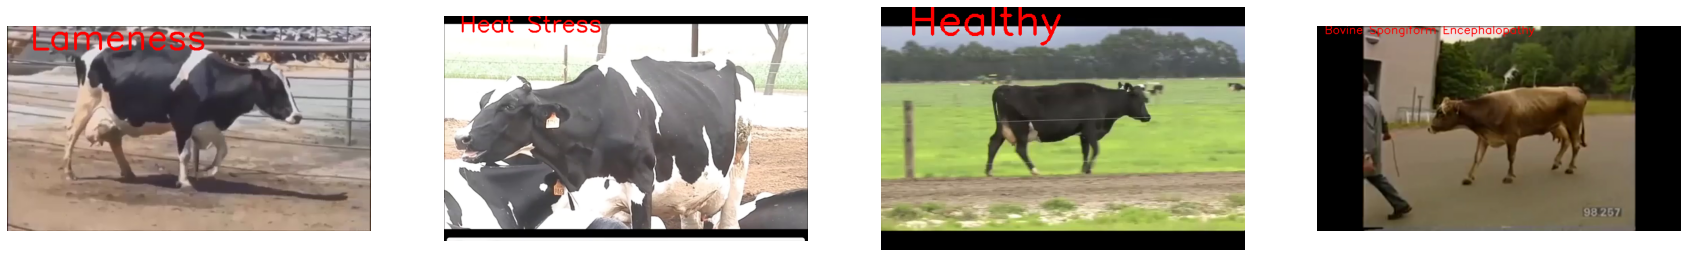

In [3]:
plt.figure(figsize = (30, 30))
 

all_classes_names = os.listdir('Cattle_Diseases')
 
random_range = random.sample(range(len(all_classes_names)), 4)
 
for counter, random_index in enumerate(random_range, 1):
 
     
    selected_class_Name = all_classes_names[random_index]               
    video_files_names_list = os.listdir(f'Cattle_Diseases/{selected_class_Name}')        
    selected_video_file_name = random.choice(video_files_names_list)             
    video_reader = cv2.VideoCapture(f'Cattle_Diseases/{selected_class_Name}/{selected_video_file_name}')         
    
   
    _, bgr_frame = video_reader.read()       
  
    video_reader.release()      
 
    rgb_frame = cv2.cvtColor(bgr_frame, cv2.COLOR_BGR2RGB)      
 
    cv2.putText(rgb_frame, selected_class_Name, (40, 40), cv2.FONT_HERSHEY_SIMPLEX, 2, (255, 0, 0), 4)      
    
    # Display the frame.
    plt.subplot(5, 4, counter);
    plt.imshow(rgb_frame);
    plt.axis('off')

In [4]:
IMAGE_HEIGHT , IMAGE_WIDTH = 64, 64         
 
SEQUENCE_LENGTH = 30            
  
DATASET_DIR = "Cattle_Diseases"     
 
# Specify the list containing the names of the classes used for training. Feel free to choose any set of classes.
CLASSES_LIST = ["Bovine Spongiform Encephalopathy", "Healthy", "Heat Stress", "Lameness"]

In [5]:
def frames_extraction(video_path):
    
    frames_list = []        

    video_reader = cv2.VideoCapture(video_path)     

    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))        
 
    skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH), 1)        
 
    # Iterate through the Video Frames.
    for frame_counter in range(SEQUENCE_LENGTH):
 
        # Set the current frame position of the video.
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)
 
        # Reading the frame from the video. 
        success, frame = video_reader.read() 
 
        # Check if Video frame is not successfully read then break the loop
        if not success:
            break
 
        # Resize the Frame to fixed height and width.
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
        
        # Normalize the resized frame by dividing it with 255 so that each pixel value then lies between 0 and 1
        normalized_frame = resized_frame / 255
        
        # Append the normalized frame into the frames list
        frames_list.append(normalized_frame)
    
    # Release the VideoCapture object. 
    video_reader.release()
 
    # Return the frames list.
    return frames_list

In [6]:
def create_dataset():
    
    # Declared Empty Lists to store the features, labels and video file path values.
    features = []
    labels = []
    video_files_paths = []
    
    # Iterating through all the classes mentioned in the classes list
    for class_index, class_name in enumerate(CLASSES_LIST):
        
        # Display the name of the class whose data is being extracted.
        print(f'Extracting Data of Class: {class_name}')
        
        # Get the list of video files present in the specific class name directory.
        files_list = os.listdir(os.path.join(DATASET_DIR, class_name))
        
        # Iterate through all the files present in the files list.
        for file_name in files_list:
            
            # Get the complete video path.
            video_file_path = os.path.join(DATASET_DIR, class_name, file_name)
 
            # Extract the frames of the video file.
            frames = frames_extraction(video_file_path)
 
            # Check if the extracted frames are equal to the SEQUENCE_LENGTH specified above.
            # So ignore the vides having frames less than the SEQUENCE_LENGTH.
            if len(frames) == SEQUENCE_LENGTH:
 
                # Append the data to their repective lists.
                features.append(frames)
                labels.append(class_index)
                video_files_paths.append(video_file_path)
 
    # Converting the list to numpy arrays
    features = np.asarray(features)
    labels = np.array(labels)  
    
    # Return the frames, class index, and video file path.
    return features, labels, video_files_paths

In [7]:
features, labels, video_files_paths = create_dataset()

Extracting Data of Class: Bovine Spongiform Encephalopathy
Extracting Data of Class: Healthy
Extracting Data of Class: Heat Stress
Extracting Data of Class: Lameness


In [8]:
one_hot_encoded_labels = to_categorical(labels)

In [9]:
features_train, features_test, labels_train, labels_test = train_test_split(features, one_hot_encoded_labels, test_size = 0.2, shuffle = True, random_state = seed_constant)

In [10]:
def create_LRCN_model():
   
    # Sequential model for model construction.
    model = Sequential()
    
    # Define the Model Architecture.
    ########################################################################################################################
    
    model.add(TimeDistributed(Conv2D(16, (3, 3), padding='same',activation = 'relu'),
                              input_shape = (SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3)))
    
    model.add(TimeDistributed(MaxPooling2D((4, 4)))) 
    model.add(TimeDistributed(Dropout(0.25)))
    
    model.add(TimeDistributed(Conv2D(32, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((4, 4))))
    model.add(TimeDistributed(Dropout(0.25)))
    
    model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Dropout(0.25)))
    
    model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    #model.add(TimeDistributed(Dropout(0.25)))
                                      
    model.add(TimeDistributed(Flatten()))
                                      
    model.add(LSTM(32))
                                      
    model.add(Dense(len(CLASSES_LIST), activation = 'softmax'))
 
    ########################################################################################################################
 
    # Display the models summary.
    model.summary()
    
    # Return the constructed LRCN model.
    return model

In [11]:
# Construct the required LRCN model.
LRCN_model = create_LRCN_model()
 
# Display the success message.
print("Model is Created Successfully!")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 30, 64, 64, 16)   448       
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 30, 16, 16, 16)   0         
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 30, 16, 16, 16)   0         
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 30, 16, 16, 32)   4640      
 tributed)                                                       
                                                                 
 time_distributed_4 (TimeDis  (None, 30, 4, 4, 32)     0

In [12]:
# Create an Instance of Early Stopping Callback.

early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 15, mode = 'min', restore_best_weights = True)
 
# Compile the model and specify loss function, optimizer and metrics to the model.

LRCN_model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])
 
# Start training the model.

LRCN_model_training_history = LRCN_model.fit(x = features_train, y = labels_train, epochs = 80, batch_size = 4 , shuffle = True, validation_split = 0.2, callbacks = [early_stopping_callback])

Epoch 1/80
27/27 [==============================] - 6s 140ms/step - loss: 1.2404 - accuracy: 0.4667 - val_loss: 1.0049 - val_accuracy: 0.7037
Epoch 2/80
27/27 [==============================] - 3s 121ms/step - loss: 1.2004 - accuracy: 0.5333 - val_loss: 0.9980 - val_accuracy: 0.7037
Epoch 3/80
27/27 [==============================] - 3s 127ms/step - loss: 1.1626 - accuracy: 0.5333 - val_loss: 1.0422 - val_accuracy: 0.7037
Epoch 4/80
27/27 [==============================] - 3s 116ms/step - loss: 1.1774 - accuracy: 0.5333 - val_loss: 0.9890 - val_accuracy: 0.7037
Epoch 5/80
27/27 [==============================] - 3s 111ms/step - loss: 1.1305 - accuracy: 0.5429 - val_loss: 0.8882 - val_accuracy: 0.7037
Epoch 6/80
27/27 [==============================] - 3s 116ms/step - loss: 0.9236 - accuracy: 0.5905 - val_loss: 0.7121 - val_accuracy: 0.7407
Epoch 7/80
27/27 [==============================] - 3s 109ms/step - loss: 0.6805 - accuracy: 0.7619 - val_loss: 0.6960 - val_accuracy: 0.7037
Epoch 

In [13]:
# Evaluate the trained model.
model_evaluation_history = LRCN_model.evaluate(features_test, labels_test)

2/2 [==============================] - 1s 39ms/step - loss: 0.6561 - accuracy: 0.7941


In [14]:
# Get the loss and accuracy from model_evaluation_history.

model_evaluation_loss, model_evaluation_accuracy = model_evaluation_history
 
# Define the string date format.
# Get the current Date and Time in a DateTime Object.
# Convert the DateTime object to string according to the style mentioned in date_time_format string.

date_time_format = '%Y_%m_%d__%H_%M_%S'
current_date_time_dt = dt.datetime.now()
current_date_time_string = dt.datetime.strftime(current_date_time_dt, date_time_format)
    
# Define a useful name for our model to make it easy for us while navigating through multiple saved models.

model_file_name = f'LRCN_model_Date&Time_{current_date_time_string}_Loss_{model_evaluation_loss}Accuracy_{model_evaluation_accuracy}.h5'
 
# Save the Model.

LRCN_model.save(model_file_name)

In [15]:
def plot_metric(model_training_history, metric_name_1, metric_name_2, plot_name):
   
    # Get metric values using metric names as identifiers.
    metric_value_1 = model_training_history.history[metric_name_1]
    metric_value_2 = model_training_history.history[metric_name_2]
    
    # Construct a range object which will be used as x-axis (horizontal plane) of the graph.
    epochs = range(len(metric_value_1))
 
    # Plot the Graph.
    plt.plot(epochs, metric_value_1, 'blue', label = metric_name_1)
    plt.plot(epochs, metric_value_2, 'red', label = metric_name_2)
 
    # Add title to the plot.
    plt.title(str(plot_name))
 
    # Add legend to the plot.
    plt.legend()

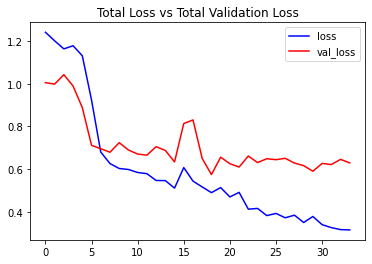

In [16]:
# Visualize the training and validation loss metrices.

plot_metric(LRCN_model_training_history, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')

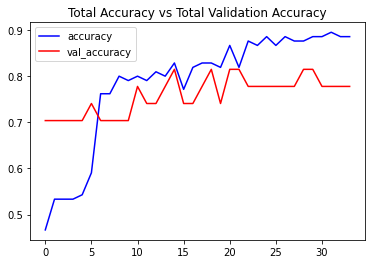

In [17]:
# Visualize the training and validation accuracy metrices.

plot_metric(LRCN_model_training_history, 'accuracy', 'val_accuracy', 'Total Accuracy vs Total Validation Accuracy')

In [18]:
def predict_on_video(video_file_path, output_file_path, SEQUENCE_LENGTH):
 
    # Initialize the VideoCapture object to read from the video file.
    video_reader = cv2.VideoCapture(video_file_path)
 
    # Get the width and height of the video.
    original_video_width = int(video_reader.get(cv2.CAP_PROP_FRAME_WIDTH))
    original_video_height = int(video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT))
 
    # Initialize the VideoWriter Object to store the output video in the disk.
    video_writer = cv2.VideoWriter(output_file_path, cv2.VideoWriter_fourcc('M', 'P', '4', 'V'), 
                                   video_reader.get(cv2.CAP_PROP_FPS), (original_video_width, original_video_height))
 
    # Declare a queue to store video frames.
    frames_queue = deque(maxlen = SEQUENCE_LENGTH)
 
    # Initialize a variable to store the predicted action being performed in the video.
    predicted_class_name = ''
 
    # Iterate until the video is accessed successfully.
    while video_reader.isOpened():
 
        # Read the frame.
        ok, frame = video_reader.read() 
        
        # Check if frame is not read properly then break the loop.
        if not ok:
            break
 
        # Resize the Frame to fixed Dimensions.
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
        
        # Normalize the resized frame by dividing it with 255 so that each pixel value then lies between 0 and 1.
        normalized_frame = resized_frame / 255
 
        # Appending the pre-processed frame into the frames list.
        frames_queue.append(normalized_frame)
 
        # Check if the number of frames in the queue are equal to the fixed sequence length.
        if len(frames_queue) == SEQUENCE_LENGTH:
 
            # Pass the normalized frames to the model and get the predicted probabilities.
            predicted_labels_probabilities = LRCN_model.predict(np.expand_dims(frames_queue, axis = 0))[0]
 
            # Get the index of class with highest probability.
            predicted_label = np.argmax(predicted_labels_probabilities)
 
            # Get the class name using the retrieved index.
            predicted_class_name = CLASSES_LIST[predicted_label]
 
        # Write predicted class name on top of the frame.
        cv2.putText(frame, predicted_class_name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
 
        # Write The frame into the disk using the VideoWriter Object.
        video_writer.write(frame)
        
    # Release the VideoCapture and VideoWriter objects.
    video_reader.release()
    video_writer.release()

In [25]:
# Construct the output video path.

input_video_file_path = f'D:/SLIIT/SLIIT_Y4S1/IT19132938_RP/BEHAVIORAL_PATTERNS/Cattle_Diseases/Bovine Spongiform Encephalopathy/aggressive1.mp4'
output_video_file_path = f'D:/SLIIT/SLIIT_Y4S1/IT19132938_RP/BEHAVIORAL_PATTERNS/test_videos/bse1_tested.mp4'
 
# Perform behavioral changes Recognition on the Test Video.

predict_on_video(input_video_file_path, output_video_file_path, SEQUENCE_LENGTH)
 
# Display the output video.

VideoFileClip(output_video_file_path, audio=False, target_resolution=(300,None)).ipython_display()

Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


In [24]:
# Construct the output video path.

input_video_file_path = f'D:/SLIIT_Y4S1/IT19132938_RP/BEHAVIORAL_PATTERNS/Cattle_Diseases/Heat Stress/heat_stress_3.mp4'
output_video_file_path = f'D:/SLIIT_Y4S1/IT19132938_RP/BEHAVIORAL_PATTERNS/test_videos/hs1_tested.mp4'
 
# Perform Action Recognition on the Test Video.

predict_on_video(input_video_file_path, output_video_file_path, SEQUENCE_LENGTH)
 
# Display the output video.

VideoFileClip(output_video_file_path, audio=False, target_resolution=(300,None)).ipython_display()

OSError: MoviePy error: the file D:/SLIIT_Y4S1/IT19132938_RP/BEHAVIORAL_PATTERNS/test_videos/hs1_tested.mp4 could not be found!
Please check that you entered the correct path.

In [23]:
# Construct the output video path.

input_video_file_path = f'D:/SLIIT/SLIIT_Y4S1/IT19132938_RP/BEHAVIORAL_PATTERNS/Cattle_Diseases/Healthy/heat_stress.mp4'
output_video_file_path = f'D:/SLIIT/SLIIT_Y4S1/IT19132938_RP/BEHAVIORAL_PATTERNS/test_videos/heat_tested.mp4'
 
# Perform Action Recognition on the Test Video.

predict_on_video(input_video_file_path, output_video_file_path, SEQUENCE_LENGTH)
 
# Display the output video.

VideoFileClip(output_video_file_path, audio=False, target_resolution=(300,None)).ipython_display()

OSError: MoviePy error: failed to read the duration of file D:/SLIIT/SLIIT_Y4S1/IT19132938_RP/BEHAVIORAL_PATTERNS/test_videos/heat_tested.mp4.
Here are the file infos returned by ffmpeg:

ffmpeg version 4.2.2 Copyright (c) 2000-2019 the FFmpeg developers
  built with gcc 9.2.1 (GCC) 20200122
  configuration: --enable-gpl --enable-version3 --enable-sdl2 --enable-fontconfig --enable-gnutls --enable-iconv --enable-libass --enable-libdav1d --enable-libbluray --enable-libfreetype --enable-libmp3lame --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenjpeg --enable-libopus --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libtheora --enable-libtwolame --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxml2 --enable-libzimg --enable-lzma --enable-zlib --enable-gmp --enable-libvidstab --enable-libvorbis --enable-libvo-amrwbenc --enable-libmysofa --enable-libspeex --enable-libxvid --enable-libaom --enable-libmfx --enable-amf --enable-ffnvcodec --enable-cuvid --enable-d3d11va --enable-nvenc --enable-nvdec --enable-dxva2 --enable-avisynth --enable-libopenmpt
  libavutil      56. 31.100 / 56. 31.100
  libavcodec     58. 54.100 / 58. 54.100
  libavformat    58. 29.100 / 58. 29.100
  libavdevice    58.  8.100 / 58.  8.100
  libavfilter     7. 57.100 /  7. 57.100
  libswscale      5.  5.100 /  5.  5.100
  libswresample   3.  5.100 /  3.  5.100
  libpostproc    55.  5.100 / 55.  5.100
[mov,mp4,m4a,3gp,3g2,mj2 @ 0000022c7b0e8e40] Format mov,mp4,m4a,3gp,3g2,mj2 detected only with low score of 1, misdetection possible!
[mov,mp4,m4a,3gp,3g2,mj2 @ 0000022c7b0e8e40] moov atom not found
D:/SLIIT/SLIIT_Y4S1/IT19132938_RP/BEHAVIORAL_PATTERNS/test_videos/heat_tested.mp4: Invalid data found when processing input


In [ ]:
def predict_single_action(video_file_path, SEQUENCE_LENGTH):
  
    # Initialize the VideoCapture object to read from the video file.
    video_reader = cv2.VideoCapture(video_file_path)
 
    # Get the width and height of the video.
    original_video_width = int(video_reader.get(cv2.CAP_PROP_FRAME_WIDTH))
    original_video_height = int(video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT))
 
    # Declare a list to store video frames we will extract.
    frames_list = []
    
    # Initialize a variable to store the predicted action being performed in the video.
    predicted_class_name = ''
 
    # Get the number of frames in the video.
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
 
    # Calculate the interval after which frames will be added to the list.
    skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH),1)
 
    # Iterating the number of times equal to the fixed length of sequence.
    for frame_counter in range(SEQUENCE_LENGTH):
 
        # Set the current frame position of the video.
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)
 
        # Read a frame.
        success, frame = video_reader.read() 
 
        # Check if frame is not read properly then break the loop.
        if not success:
            break
 
        # Resize the Frame to fixed Dimensions.
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
        
        # Normalize the resized frame by dividing it with 255 so that each pixel value then lies between 0 and 1.
        normalized_frame = resized_frame / 255
        
        # Appending the pre-processed frame into the frames list
        frames_list.append(normalized_frame)
 
    # Passing the  pre-processed frames to the model and get the predicted probabilities.
    predicted_labels_probabilities = LRCN_model.predict(np.expand_dims(frames_list, axis = 0))[0]
 
    # Get the index of class with highest probability.
    predicted_label = np.argmax(predicted_labels_probabilities)
 
    # Get the class name using the retrieved index.
    predicted_class_name = CLASSES_LIST[predicted_label]
    
    # Display the predicted action along with the prediction confidence.
    print(f'Predicted Disease reasoned for the behavioral change : {predicted_class_name}\nConfidence: {predicted_labels_probabilities[predicted_label]}\n\n')
        
    # Release the VideoCapture object. 
    video_reader.release()